Epoch 50/300, Loss = 0.0898
Epoch 100/300, Loss = 0.0377
Epoch 150/300, Loss = 0.0232
Epoch 200/300, Loss = 0.0165
Epoch 250/300, Loss = 0.0128
Epoch 300/300, Loss = 0.0104


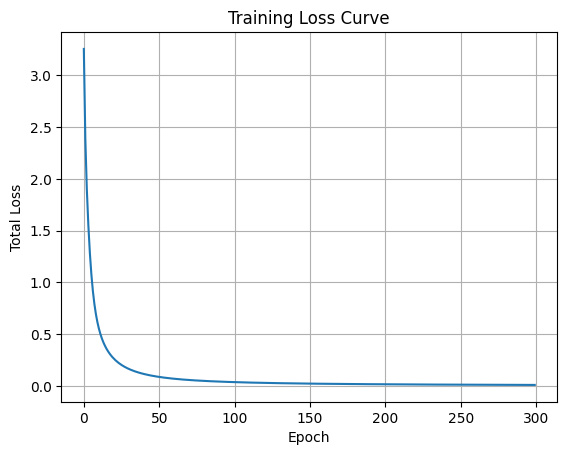


=== Testing ===
['The', 'movie', 'is', 'bad'] → Prediction: 0
['The', 'movie', 'is', 'good'] → Prediction: 1


In [6]:
import torch
import matplotlib.pyplot as plt

# 1. Prepare the dictionary and the one-hot helper
vocab = {"The": 0, "movie": 1, "is": 2, "good": 3, "bad": 4}

def word_to_onehot(word):
    vec = torch.zeros(len(vocab), 1)   # shape (5×1) filled with zeros
    idx = vocab[word]
    vec[idx, 0] = 1.0                  # set the slot of the word to 1
    return vec

# 2. Training data: two sentences + labels
train_data = [
    (["The", "movie", "is", "good"], 1),
    (["The", "movie", "is", "bad"],  0),
]

# 3. RNN hyper-parameters
hidden_size = 2
input_size  = len(vocab)    # 5
output_size = 2             # two classes: good / bad

torch.manual_seed(42)       # reproducibility

# Randomly initialize weights; biases are zero
W      = torch.randn(hidden_size, hidden_size, requires_grad=True)  # hidden→hidden
U      = torch.randn(hidden_size, input_size,      requires_grad=True)  # input→hidden
b      = torch.zeros(hidden_size, 1,               requires_grad=True)  # hidden bias
W_out  = torch.randn(output_size, hidden_size,     requires_grad=True)  # hidden→output
b_out  = torch.zeros(output_size, 1,               requires_grad=True)  # output bias

# 4. Training settings
lr         = 0.1
n_epochs   = 300
loss_fn    = torch.nn.CrossEntropyLoss()
loss_curve = []

# 5. Training loop
for epoch in range(1, n_epochs + 1):
    epoch_loss = 0.0

    # iterate over each training sentence
    for sentence, label in train_data:
        # (a) forward pass
        s_prev = torch.zeros(hidden_size, 1)      # initial hidden state
        for word in sentence:
            x = word_to_onehot(word)
            # hidden update: s_t = tanh(W s_{t-1} + U x + b)
            s_t = torch.tanh(W @ s_prev + U @ x + b)
            s_prev = s_t

        # (b) output layer
        logits = W_out @ s_prev + b_out           # shape (2,1)
        logits = logits.view(1, -1)               # reshape to (1,2) for CrossEntropy

        # (c) loss
        target = torch.tensor([label])
        loss   = loss_fn(logits, target)
        epoch_loss += loss.item()

        # (d) backward pass
        loss.backward()

        # (e) manual SGD update
        with torch.no_grad():
            W.data     -= lr * W.grad.data
            U.data     -= lr * U.grad.data
            b.data     -= lr * b.grad.data
            W_out.data -= lr * W_out.grad.data
            b_out.data -= lr * b_out.grad.data

            # reset gradients to avoid accumulation
            W.grad.zero_()
            U.grad.zero_()
            b.grad.zero_()
            W_out.grad.zero_()
            b_out.grad.zero_()

    loss_curve.append(epoch_loss)
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss = {epoch_loss:.4f}")

# 6. Plot the loss curve
plt.plot(loss_curve)
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# 7. Testing
print("\n=== Testing ===")
test_sentences = [
    ["The", "movie", "is", "bad"],
    ["The", "movie", "is", "good"]
]
for sent in test_sentences:
    s_prev = torch.zeros(hidden_size, 1)
    for w in sent:
        x = word_to_onehot(w)
        s_prev = torch.tanh(W @ s_prev + U @ x + b)
    logits     = W_out @ s_prev + b_out
    pred_label = torch.argmax(logits).item()
    print(f"{sent} → Prediction: {pred_label}")
